<div style="line-height:0.5">
<h1 style="color:#0AE42F "> K-means method 3 </h1>
<h4> K-means clustering using PyTorch API. </h4>
<div style="margin-top: 4px;">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> Lloyd's algorithm + pykeops + KMeans_cosine
</span>
</div>

In [6]:
import time
import torch
from matplotlib import pyplot as plt
from pykeops.torch import LazyTensor

use_cuda = torch.cuda.is_available()
dtype = torch.float32 if use_cuda else torch.float64
device_id = "cuda:0" if use_cuda else "cpu"

<h3 style="color:#0AE42F "> Recap:  </h3>
<div style="margin-top: -10px;">

PyKeOps module for performing fast mathematical large-scale operations on GPU using PyTorch. <br>
Especially optimize operations like kernel computations. <br>

LazyTensor in PyKeOps represents a symbolic computation object that allows you to define mathematical operations symbolically <br>  without immediately evaluating them. 
</div>

In [7]:
def KMeans(x, K=10, Niter=10, verbose=True):
    """ Kmeans implementation. Lloyd's algorithm for the Euclidean metric.
        
    Details:
        - K-means loop:
            - x  is the (N, D) point cloud,
            - cl is the (N,) vector of class labels
            - c  is the (K, D) cloud of cluster centroids
    """
    start = time.time()
    # Get the number of samples and dimension of the ambient space
    N, D = x.shape                      
    # Initializ3 for the centroids
    c = x[:K, :].clone()                
    x_i = LazyTensor(x.view(N, 1, D))   #(N, 1, D) samples
    c_j = LazyTensor(c.view(1, K, D))   #(1, K, D) centroids


    for i in range(Niter):
        # E step: assign points to the closest cluster 
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (N, K) symbolic squared distances
        # Points -> Nearest cluster
        cl = D_ij.argmin(dim=1).long().view(-1)  

        # M step: update the centroids to the normalized cluster average: 
            # compute the sum of points per cluster
        c.zero_()
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Divide by the number of points per cluster
        Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
        c /= Ncl  # in-place division to compute the average

    ##### Fancy display 
    if verbose:
        if use_cuda:
            torch.cuda.synchronize()
        end = time.time()
        print(f"K-means for the Euclidean metric with {N:,} points in dimension {D:,}, K = {K:,}:")
        print("Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(Niter, end - start, Niter, (end - start) / Niter))

    return cl, c

<h2 style="color:#0AE42F "> K-means in 2D </h2>

In [8]:
""" N=10,000 points in dimension D=2, with K=50 classes """
N, D, K = 10000, 2, 50

In [9]:
x = 0.7 * torch.randn(N, D, dtype=dtype, device=device_id) + 0.3
x

tensor([[-0.3258,  0.5070],
        [-0.1147,  0.5282],
        [-0.2152,  0.5442],
        ...,
        [ 0.4472, -0.2602],
        [ 0.3411, -0.0757],
        [ 0.5617, -1.2237]], dtype=torch.float64)

In [10]:
cl, c = KMeans(x, K)

[KeOps] Generating code for formula ArgMin_Reduction(Sum((Var(0,2,0)-Var(1,2,1))**2),0) ... OK
[pyKeOps] Compiling pykeops cpp 1da1e64163 module ... OK
K-means for the Euclidean metric with 10,000 points in dimension 2, K = 50:
Timing for 10 iterations: 7.23767s = 10 x 0.72377s



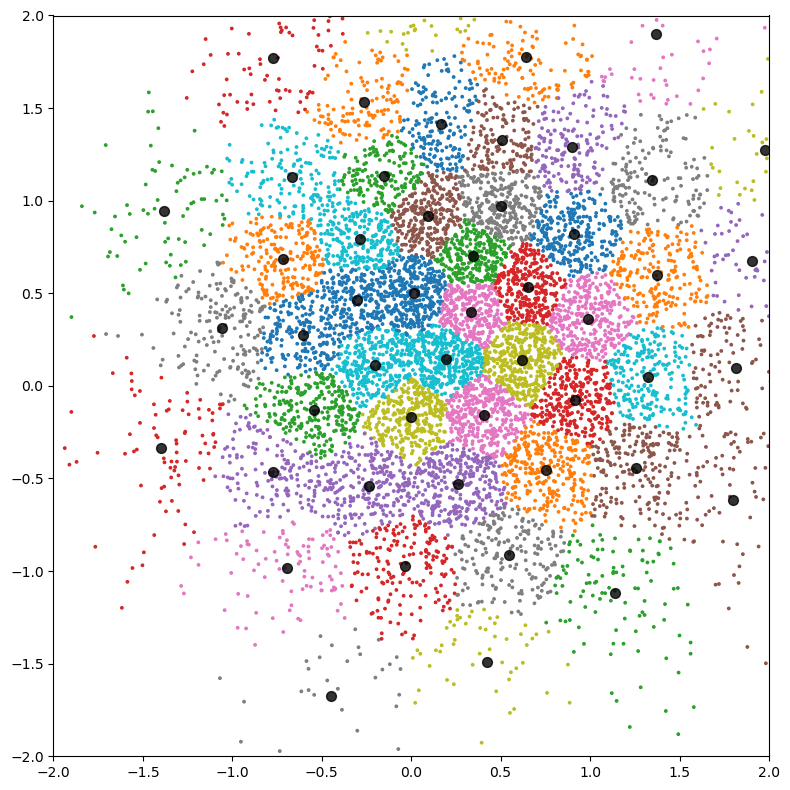

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl.cpu(), s=30000 / len(x), cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c="black", s=50, alpha=0.8)
plt.axis([-2, 2, -2, 2])
plt.tight_layout()
plt.show()

In [12]:
def KMeans_cosine(x, K=10, Niter=10, verbose=True):
    """Implements Lloyd's algorithm for the Cosine similarity metric. """

    start = time.time()
    # Number of samples, dimension of the ambient space
    N, D = x.shape  
    # Simplistic initialization for the centroids
    c = x[:K, :].clone()  
    # Normalize the centroids for the cosine similarity:
    c = torch.nn.functional.normalize(c, dim=1, p=2)

    x_i = LazyTensor(x.view(N, 1, D))  # (N, 1, D) samples
    c_j = LazyTensor(c.view(1, K, D))  # (1, K, D) centroids
    """ 
    K-means loop:
    - x  is the (N, D) point cloud,
    - cl is the (N,) vector of class labels
    - c  is the (K, D) cloud of cluster centroids 
    """
    for i in range(Niter):
        # E step: assign points to the closest cluster 
        S_ij = x_i | c_j  # (N, K) symbolic Gram matrix of dot products
        # Points -> Nearest cluster
        cl = S_ij.argmax(dim=1).long().view(-1)  

        # M step: update the centroids to the normalized cluster average
            # compute the sum of points per cluster:
        c.zero_()
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Normalize the centroids
        c[:] = torch.nn.functional.normalize(c, dim=1, p=2)

    # Fancy display 
    if verbose:  
        if use_cuda:
            torch.cuda.synchronize()
        end = time.time()
        print(f"K-means for the cosine similarity with {N:,} points in dimension {D:,}, K = {K:,}:")
        print("Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(Niter, end - start, Niter, (end - start) / Niter))

    return cl, c

In [13]:
cl, c = KMeans_cosine(x, K)

[KeOps] Generating code for formula ArgMax_Reduction(Var(0,2,0)|Var(1,2,1),0) ... OK
[pyKeOps] Compiling pykeops cpp 4988f2abe4 module ... OK
K-means for the cosine similarity with 10,000 points in dimension 2, K = 50:
Timing for 10 iterations: 7.62031s = 10 x 0.76203s



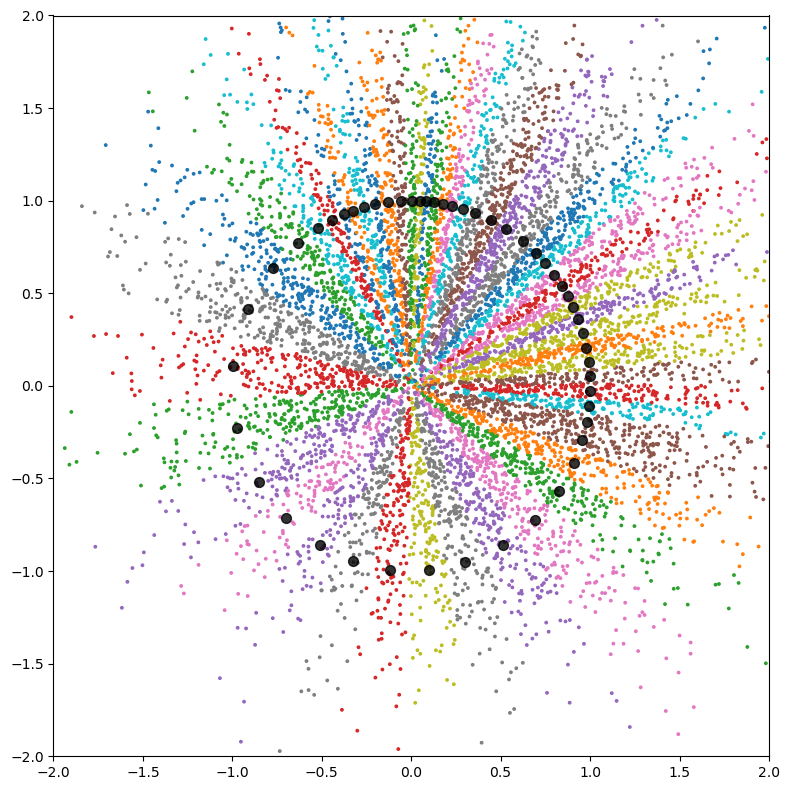

In [14]:
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl.cpu(), s=30000 / len(x), cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c="black", s=50, alpha=0.8)
plt.axis([-2, 2, -2, 2])
plt.tight_layout()
plt.show()

In [15]:
"""  N=1,000,000 points in dimension D=100, with K=1,000 classes """
if use_cuda:
    N, D, K = 1000000, 100, 1000
    x = torch.randn(N, D, dtype=dtype, device=device_id)
    cl, c = KMeans(x, K)
    cl, c = KMeans_cosine(x, K)